In [3]:
import sys
sys.path.append('../vysxd')
from vysxd_analysis import *
from vysxd_define import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

In [6]:
def density_transform(v: float, t: float, x: np.array):
    gamma = 1/np.sqrt(1-v**2)

    t1 = np.zeros(len(x))+t
    x1 = x

    t2 = gamma*(t1 - v*x1)
    x2 = gamma*(x1 - v*t1)
    return t2,x2

In [33]:
p1x1_files = np.sort(os.listdir('data/MS/PHA/p1x1/electrons/')) # Create a sorted list of filenames you will be analyzing
p1x1_temp = vysxd_get_data(f'data/MS/PHA/p1x1/electrons/{p1x1_files[0]}') # pick out the first timestep for reasons
time_prime, x_prime = density_transform(v=0.10,t=p1x1_temp.TIME[0],x=p1x1_temp.X) # use first timest
density = -np.trapz(p1x1_temp.DATA, axis=0)

for file in p1x1_files[1:]:
    p1x1 = vysxd_get_data(f'data/MS/PHA/p1x1/electrons/{file}') # Pull the phase space data
    time_prime_temp,x_prime_temp = density_transform(v=0.10,t=p1x1.TIME[0],x=p1x1.X)
    density_temp = -np.trapz(p1x1.DATA, axis=0)

    time_prime = np.vstack((time_prime, time_prime_temp))
    x_prime = np.vstack((x_prime, x_prime_temp))
    density = np.vstack((density, density_temp))

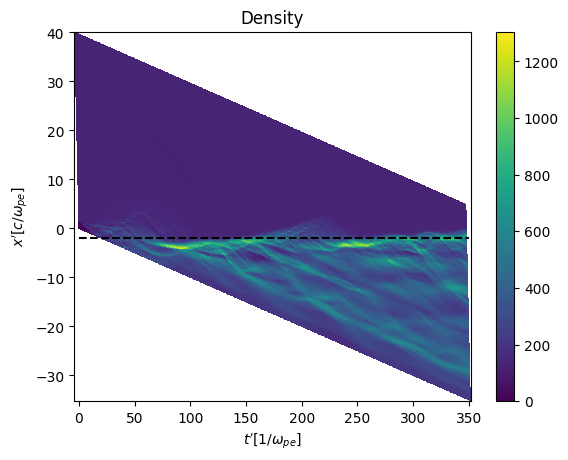

In [34]:
d_min, d_max = np.abs(density).min(), np.abs(density).max()

c = plt.pcolormesh(time_prime, x_prime, density, vmin = d_min, vmax = d_max)
plt.colorbar(c)
plt.ylabel(r'$x^\prime [c/\omega_{pe}]$')
plt.xlabel(r'$t^\prime [1/\omega_{pe}]$')
plt.hlines(-2,0,350, colors = 'black', linestyles= '--')
plt.title('Density')
plt.show()

In [ ]:
p1x1 = vysxd_get_data(f'data/MS/PHA/p1x1/electrons/{p1x1_files[1]}')

In [ ]:
p1x1.TIME

array([0.76])

In [ ]:
p1x1_files[1:]

array(['p1x1-electrons-000001.h5', 'p1x1-electrons-000002.h5',
       'p1x1-electrons-000003.h5', 'p1x1-electrons-000004.h5',
       'p1x1-electrons-000005.h5', 'p1x1-electrons-000006.h5',
       'p1x1-electrons-000007.h5', 'p1x1-electrons-000008.h5',
       'p1x1-electrons-000009.h5', 'p1x1-electrons-000010.h5',
       'p1x1-electrons-000011.h5', 'p1x1-electrons-000012.h5',
       'p1x1-electrons-000013.h5', 'p1x1-electrons-000014.h5',
       'p1x1-electrons-000015.h5', 'p1x1-electrons-000016.h5',
       'p1x1-electrons-000017.h5', 'p1x1-electrons-000018.h5',
       'p1x1-electrons-000019.h5', 'p1x1-electrons-000020.h5',
       'p1x1-electrons-000021.h5', 'p1x1-electrons-000022.h5',
       'p1x1-electrons-000023.h5', 'p1x1-electrons-000024.h5',
       'p1x1-electrons-000025.h5', 'p1x1-electrons-000026.h5',
       'p1x1-electrons-000027.h5', 'p1x1-electrons-000028.h5',
       'p1x1-electrons-000029.h5', 'p1x1-electrons-000030.h5',
       'p1x1-electrons-000031.h5', 'p1x1-electrons-0000

[[1 2 3]
 [7 8 9]
 [4 5 6]]
